In [1]:
import numpy as np
import os
#Visualizations
import matplotlib.pyplot as plt
import random
from datetime import datetime
import itertools
import scipy as sp
from scipy import linalg
import time as tm

## Functions

In [2]:
#generateRandA creates a directed random matrix
#Input:
#vertices: # of vertices
#edges: # of edges (nonzero entries on the random matrix)
#weightDistribution: could be 'binary', 'normal' or 'lognormal'
#mu = the mu parameter, is not valid for binary
#sig = the sig parameter, is not valid for binary
#Output:
#A: the verticesXvertices random digraph
#

def generateRandA(vertices, edges, **kwargs):

    for key, value in kwargs.items():
        if key == 'weightDistribution':
            weightDistribution = value
        elif key == 'mu':
            mu = value
        elif key == 'sig':
            sig = value

    maxConnections = int(vertices * (vertices - 1))  # the maximum connections a network can have
    epsilon = 0.05
    if edges > maxConnections or edges < 0:
        print('The number of edges are not within the permitted range')
        return -1

    # I use lognormal for the time being. We can make it into a parameter
    if weightDistribution == 'lognormal':
        if ('mu' not in locals())|('sig' not in locals()):
            mu, sig = 0., 1.

        randWeights = np.random.lognormal(mean=mu, sigma=sig, size=edges)
    
    elif weightDistribution == 'normal':
        if ('mu' not in locals())|('sig' not in locals()):
            mu, sig = 1., 0.25

        randWeights = np.random.normal(loc=mu, scale=sig, size=edges)
        ind = np.where(randWeights < 0)
        randWeights[ind] = epsilon

    elif weightDistribution == 'binary':
        randWeights = np.ones(edges)

    # normRandWeights = randWeights / np.max(randWeights)  # normalize so that the values are between 0 and 1
    # Normalize so that the sum of the weights equals the number of edges
    if (weightDistribution == 'normal')|(weightDistribution == 'lognormal'):
        normFactor = len(randWeights) / np.sum(randWeights)
        normRandWeights = randWeights * normFactor
    else:
        normRandWeights = randWeights

    # Get the indices of 1s of a matrix the same size as A with 1s everywhere except in the diagonal
    Aones = np.ones((vertices, vertices)) - np.eye(vertices)
    ind = np.where(Aones)
    # Get a random sample of those indices (#edges)
    xxRand = np.random.permutation(maxConnections)
    indRand = (ind[0][xxRand[:edges]], ind[1][xxRand[:edges]])
    # construct with those indices the adjacency matrix
    A = np.zeros((vertices, vertices))
    A[indRand] = normRandWeights


    return A


In [3]:
# rewireOutConsensus rewires iteratively a matrix A. At each iteration the rewiring can be random 
#(probability= pRandRewire) or according to a consensus function (probability = 1-pRandRewire).
#It rewires only the OUTDEGREES. More specifically, during each rewiring iteration a random node k is selected
#and one of its outdegrees is cut, and a connection is added with the head being k. It operates in the columns
#Works for both binary and weighted initial networks since this implementation just redistributes the weights
# INPUT
# AInit: initial adjacency matrix
# pRandRewire: probability of random rewiring
# rewirings: number of iterations the wiring take place
# tau: heat dispersion parameter
# OUTPUT
# A: returns a rewired matrix
def rewireOutConsensus(AInit, pRandRewire, rewirings, tau):

    A = AInit.copy()

    vertices = A.shape[0]
    I = 1.0 * np.eye(vertices)

    for k in range(rewirings):

        degIn = np.sum(A > 0, axis=0, keepdims=False)  # deg[i] = # of incoming connections to the i+1 node
        degOut = np.sum(A > 0, axis=1, keepdims=False)  # deg[i] = # of outgoing connections from the i+1 node
        
        ## take the indices of the nodes with nonzero but not numofVertices degree for both in and out-degree
        vNonZeroInInd = np.where((degIn > 0) & (degIn < vertices - 1))  
        vNonZeroOutInd = np.where((degOut > 0) & (degOut < vertices - 1)) 
        
        vNonZeroInd = np.intersect1d(vNonZeroInInd[0],vNonZeroOutInd[0])
        if (len(vNonZeroInd) == 0):
            print('For tau = %f, and p(rand) = %f,the graph is problematic' % (tau, pRandRewire))
            return A
        
        vRandInd = np.random.choice(vNonZeroInd)  # pick one of those indices at random

        indAll = np.arange(vertices)  # 0:vertices-1
        indMinusV = np.delete(indAll, vRandInd)  # remove the vRandInd index, ie for VRandInd=2 indMinusV = 0,1,3,..
        
        #for the outdegrees
        ANotVCol = 1.0 * np.logical_not(A[indMinusV, vRandInd])  # take the actual vector and make inversions 0->1 and 1->0
                
        if np.random.random_sample() >= pRandRewire:  # rewire by network diffusion

            #estimate the in degree Laplacian and calculate the consensus kernel
            DinVec = np.sum(A,axis=0); Din = np.diag(DinVec); Lin = Din - A
            h = linalg.expm(-tau * Lin)  # consensus kernel

            #for the out-degrees
            indTestableOut = np.where(A[:, vRandInd] > 0)[0]  # do not include the 0s
            u1TestableOut = np.argmin(h[indTestableOut, vRandInd])  # check the consenus kernel minimum value of the nodes connected to vRandInd
            #print('min of connected is ',np.min(h[indTestableOut, vRandInd]))
            u1Out = indTestableOut[u1TestableOut]
            
            indANotVCol = np.where(ANotVCol > 0)[0]
            indNotConnectedOut = indMinusV[indANotVCol]
            u2IndTempOut = np.argmax(h[indNotConnectedOut, vRandInd])  # what would happen if the ones that were connected to vRandInd were connected to it and was applied to them the heat kernel. Get the ind of the maximum from those nodes. this will be used for reconnection
            #print('max of disconnected is',np.max(h[indNotConnectedOut, vRandInd]))
            #print('')
            u2Out = indNotConnectedOut[u2IndTempOut]  # get the right u2 node
            
                        
        else:  # now we just randomly rewire
            noConnIndexOut = np.argwhere(ANotVCol)
            u2IndTempOut = noConnIndexOut[np.random.choice(noConnIndexOut.size)][0]
            u2Out = indMinusV[u2IndTempOut]  # pick randomly a nonconnection to vRandInd node

            AOnesIndOut = np.argwhere(A[:, vRandInd] > 0)
            u1Out = AOnesIndOut[np.random.choice(AOnesIndOut.size)][0]  # pick randomly a connected node to vRandInd

        if u1Out == u2Out:
            print('Problem')
            print('The A nodes rewired are %d and %d with weight %f' % (u2Out, vRandInd, A[u1Out, vRandInd]))
            print('The A nodes disconnected are %d and %d' % (u1Out, vRandInd))
        A[u2Out, vRandInd] = A[u1Out, vRandInd]
        A[u1Out, vRandInd] = 0

        
    return A

In [4]:
# rewireInConsensus rewires iteratively a matrix A. At each iteration the rewiring can be random 
#(probability= pRandRewire) or according to a consensus function (probability = 1-pRandRewire).
#It rewires only the INDEGREES. More specifically, during each rewiring iteration a random node k is selected
#and one of its indegrees is cut, and a connection is added with the tail being k. It operates in the rows
# INPUT
# AInit: initial adjacency matrix
# pRandRewire: probability of random rewiring
# rewirings: number of iterations the wiring take place
# tau: heat dispersion parameter
# OUTPUT
# A: returns a rewired symmetric matrix
def rewireInConsensus(AInit, pRandRewire, rewirings, tau):

    A = AInit.copy()

    vertices = A.shape[0]
    I = 1.0 * np.eye(vertices)

    for k in range(rewirings):

        degIn = np.sum(A > 0, axis=0, keepdims=False)  # deg[i] = # of incoming connections to the i+1 node
        degOut = np.sum(A > 0, axis=1, keepdims=False)  # deg[i] = # of outgoing connections from the i+1 node
        
        ## take the indices of the nodes with nonzero but not numofVertices degree for both in and out-degree
        vNonZeroInInd = np.where((degIn > 0) & (degIn < vertices - 1))  
        vNonZeroOutInd = np.where((degOut > 0) & (degOut < vertices - 1)) 
        
        vNonZeroInd = np.intersect1d(vNonZeroInInd[0],vNonZeroOutInd[0])
        if (len(vNonZeroInd) == 0):
            print('For tau = %f, and p(rand) = %f,the graph is problematic' % (tau, pRandRewire))
            return A
        
        vRandInd = np.random.choice(vNonZeroInd)  # pick one of those indices at random

        indAll = np.arange(vertices)  # 0:vertices-1
        indMinusV = np.delete(indAll, vRandInd)  # remove the vRandInd index, ie for VRandInd=2 indMinusV = 0,1,3,..
        
        #for the indegrees
        ANotVRow = 1.0 * np.logical_not(A[vRandInd,indMinusV])
                
        if np.random.random_sample() >= pRandRewire:  # rewire by network diffusion

            #estimate the in degree Laplacian and calculate the consensus kernel
            DinVec = np.sum(A,axis=0); Din = np.diag(DinVec); Lin = Din - A
            h = linalg.expm(-tau * Lin)  # consensus kernel

            #for the in-degrees
            indTestableIn = np.where(A[vRandInd,:] > 0)[0]  # do not include the 0s
            u1TestableIn = np.argmin(h[vRandInd, indTestableIn])  # check the consenus kernel minimum value of the nodes connected to vRandInd
            #print('min of connected is ',np.min(h[vRandInd, indTestableIn]))
            u1In = indTestableIn[u1TestableIn]
            
            indANotVRow = np.where(ANotVRow > 0)[0]
            indNotConnectedIn = indMinusV[indANotVRow]
            u2IndTempIn = np.argmax(h[vRandInd,indNotConnectedIn])  # what would happen if the ones that were connected to vRandInd were connected to it and was applied to them the heat kernel. Get the ind of the maximum from those nodes. this will be used for reconnection
            #print('max of disconnected is',np.max(h[vRandInd,indNotConnectedIn]))
            #print('')
            u2In = indNotConnectedIn[u2IndTempIn]  # get the right u2 node    
                        
        else:  # now we just randomly rewire
            noConnIndexIn = np.argwhere(ANotVRow)
            u2IndTempIn = noConnIndexIn[np.random.choice(noConnIndexIn.size)][0]
            u2In = indMinusV[u2IndTempIn]  # pick randomly a nonconnection to vRandInd node

            AOnesIndIn = np.argwhere(A[vRandInd,:] > 0)
            u1In = AOnesIndIn[np.random.choice(AOnesIndIn.size)][0]  # pick randomly a connected node to vRandInd

        if u1In == u2In:
            print('Problem')
            print('The A nodes rewired are %d and %d with weight %f' % (u2In, vRandInd, A[u1In, vRandInd]))
            print('The A nodes disconnected are %d and %d' % (u1In, vRandInd))
        
        #cut and rewire in-degree
        A[vRandInd,u2In] = A[vRandInd,u1In]
        A[vRandInd,u1In] = 0

        
    return A

In [5]:
# rewireOutConsensus rewires iteratively a matrix A. At each iteration the rewiring can be random 
#(probability= pRandRewire) or according to a consensus function (probability = 1-pRandRewire).
#It rewires both the OUTDEGREES and INDEGREES 
# INPUT
# AInit: initial adjacency matrix
# pRandRewire: probability of random rewiring
# rewirings: number of iterations the wiring take place
# tau: heat dispersion parameter
# OUTPUT
# A: returns a rewired symmetric matrix
def rewireInAndOutConsensus(AInit, pRandRewire, rewirings, tau):

    A = AInit.copy()

    vertices = A.shape[0]
    I = 1.0 * np.eye(vertices)

    for k in range(rewirings):

        degIn = np.sum(A > 0, axis=0, keepdims=False)  # deg[i] = # of incoming connections to the i+1 node
        degOut = np.sum(A > 0, axis=1, keepdims=False)  # deg[i] = # of outgoing connections from the i+1 node
        
        ## take the indices of the nodes with nonzero but not numofVertices degree for both in and out-degree
        vNonZeroInInd = np.where((degIn > 0) & (degIn < vertices - 1))  
        vNonZeroOutInd = np.where((degOut > 0) & (degOut < vertices - 1)) 
        
        vNonZeroInd = np.intersect1d(vNonZeroInInd[0],vNonZeroOutInd[0])
        if (len(vNonZeroInd) == 0):
            print('For tau = %f, and p(rand) = %f,the graph is problematic' % (tau, pRandRewire))
            return A
        
        vRandInd = np.random.choice(vNonZeroInd)  # pick one of those indices at random

        indAll = np.arange(vertices)  # 0:vertices-1
        indMinusV = np.delete(indAll, vRandInd)  # remove the vRandInd index, ie for VRandInd=2 indMinusV = 0,1,3,..
        
        #for the outdegrees
        ANotVCol = 1.0 * np.logical_not(A[indMinusV, vRandInd])  # take the actual vector and make inversions 0->1 and 1->0
        #for the indegrees
        ANotVRow = 1.0 * np.logical_not(A[vRandInd,indMinusV])
                
        if np.random.random_sample() >= pRandRewire:  # rewire by network diffusion

            #estimate the in degree Laplacian and calculate the consensus kernel
            DinVec = np.sum(A,axis=0); Din = np.diag(DinVec); Lin = Din - A
            h = linalg.expm(-tau * Lin)  # consensus kernel
            
            ##########REWIRING FOR THE IN-DEGREE OF THE V_RAND_IND NODE (ROWISE)#############################
            #for the in-degrees
            indTestableIn = np.where(A[vRandInd,:] > 0)[0]  # do not include the 0s
            u1TestableIn = np.argmin(h[vRandInd, indTestableIn])  # check the consenus kernel minimum value of the nodes connected to vRandInd
            #print('min of connected is ',np.min(h[vRandInd, indTestableIn]))
            u1In = indTestableIn[u1TestableIn]
            
            indANotVRow = np.where(ANotVRow > 0)[0]
            indNotConnectedIn = indMinusV[indANotVRow]
            u2IndTempIn = np.argmax(h[vRandInd,indNotConnectedIn])  # what would happen if the ones that were connected to vRandInd were connected to it and was applied to them the heat kernel. Get the ind of the maximum from those nodes. this will be used for reconnection
            #print('max of disconnected is',np.max(h[vRandInd,indNotConnectedIn]))
            u2In = indNotConnectedIn[u2IndTempIn]  # get the right u2 node
            
            ####REWIRING FOR THE OUT-DEGREE OF THE V_RAND_IND NODE (COLUMNWISE)#############################  
            #for the out-degrees
            indTestableOut = np.where(A[:, vRandInd] > 0)[0]  # do not include the 0s
            u1TestableOut = np.argmin(h[indTestableOut, vRandInd])  # check the consenus kernel minimum value of the nodes connected to vRandInd
            #print('min of connected is ',np.min(h[indTestableOut, vRandInd]))
            u1Out = indTestableOut[u1TestableOut]
            
            indANotVCol = np.where(ANotVCol > 0)[0]
            indNotConnectedOut = indMinusV[indANotVCol]
            u2IndTempOut = np.argmax(h[indNotConnectedOut, vRandInd])  # what would happen if the ones that were connected to vRandInd were connected to it and was applied to them the heat kernel. Get the ind of the maximum from those nodes. this will be used for reconnection
            #print('max of disconnected is',np.max(h[indNotConnectedOut, vRandInd]))
            #print('')
            u2Out = indNotConnectedOut[u2IndTempOut]  # get the right u2 node            
            
            
                                    
        else:  # or randomly rewire
            
            ##########REWIRING FOR THE IN-DEGREE
            noConnIndexIn = np.argwhere(ANotVRow)
            u2IndTempIn = noConnIndexIn[np.random.choice(noConnIndexIn.size)][0]
            u2In = indMinusV[u2IndTempIn]  # pick randomly a nonconnection to vRandInd node

            AOnesIndIn = np.argwhere(A[vRandInd,:] > 0)
            u1In = AOnesIndIn[np.random.choice(AOnesIndIn.size)][0]  # pick randomly a connected node to vRandInd

            ##########REWIRING FOR THE OUT-DEGREE
            noConnIndexOut = np.argwhere(ANotVCol)
            u2IndTempOut = noConnIndexOut[np.random.choice(noConnIndexOut.size)][0]
            u2Out = indMinusV[u2IndTempOut]  # pick randomly a nonconnection to vRandInd node

            AOnesIndOut = np.argwhere(A[:, vRandInd] > 0)
            u1Out = AOnesIndOut[np.random.choice(AOnesIndOut.size)][0]  # pick randomly a connected node to vRandInd
            
            
        if (u1In == u2In)| (u1Out == u2Out):
            print('Problem')
            
        #cut and rewire in-degree
        A[vRandInd,u2In] = A[vRandInd,u1In]
        A[vRandInd,u1In] = 0
        
        #cut and rewire out-degree
        A[u2Out, vRandInd] = A[u1Out, vRandInd]
        A[u1Out, vRandInd] = 0

        
    return A

## Example of the three different rewiring versions

In [6]:
vertices = 100
edges = int(np.round(2 * np.log(vertices) * (vertices - 1), decimals=0))
#edges = int(np.round(np.log(vertices) * (vertices - 1)/2, decimals=0))
print(edges)

rewirings= 10000
pRand = 0
tau = 100

ARand = generateRandA(vertices, edges, weightDistribution = 'binary')

AOut = rewireOutConsensus(ARand, pRand, rewirings, tau)

AIn = rewireInConsensus(ARand, pRand, rewirings, tau)

A = rewireInAndOutConsensus(ARand, pRand, rewirings, tau)


912


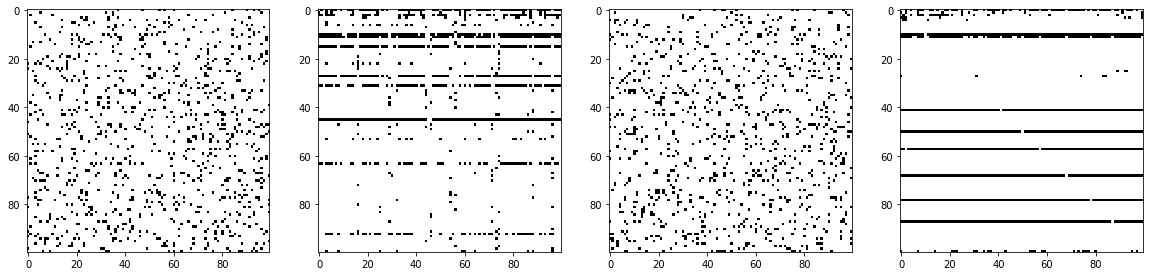

In [7]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.subplot(1,4,1)
plt.imshow(ARand, cmap='Greys')

plt.subplot(1,4,2)
plt.imshow(AOut, cmap='Greys')

plt.subplot(1,4,3)
plt.imshow(AIn, cmap='Greys')

plt.subplot(1,4,4)
plt.imshow(A, cmap='Greys')

plt.show()

(array([ 1.,  5., 15.,  9., 26., 25.,  6.,  9.,  1.,  3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

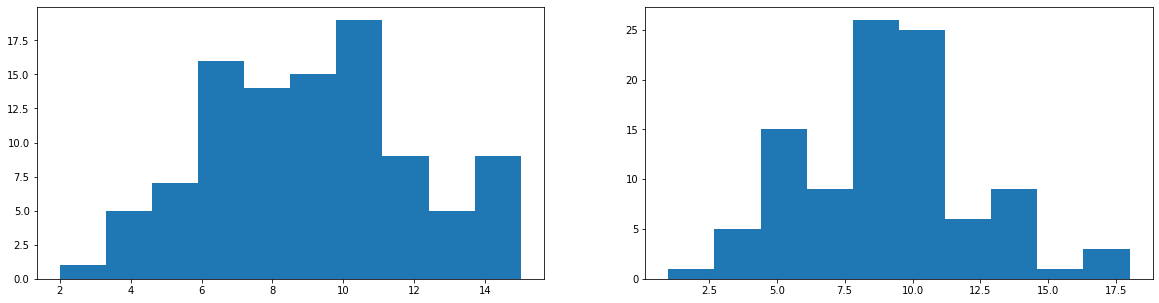

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(ARand,axis=1))

plt.subplot(1,2,2)
plt.hist(np.sum(ARand,axis=0))

(array([ 8., 10., 41., 18., 14.,  8.,  0.,  0.,  0.,  1.]),
 array([ 5. ,  6.4,  7.8,  9.2, 10.6, 12. , 13.4, 14.8, 16.2, 17.6, 19. ]),
 <a list of 10 Patch objects>)

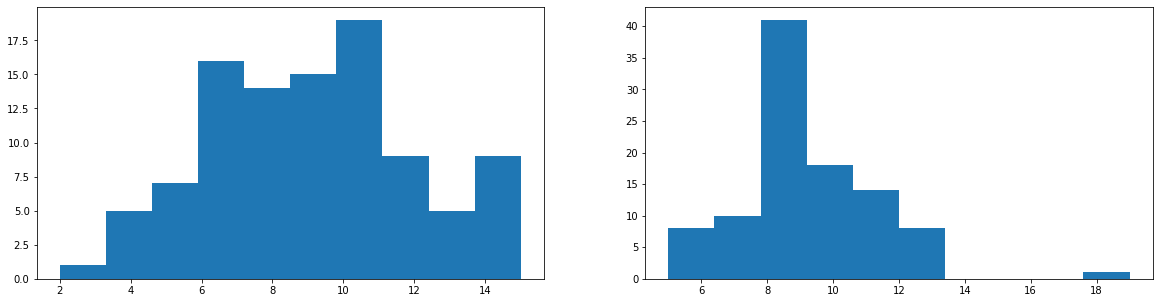

In [9]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(AIn,axis=1))

plt.subplot(1,2,2)
plt.hist(np.sum(AIn,axis=0))

(array([ 1.,  5., 15.,  9., 26., 25.,  6.,  9.,  1.,  3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

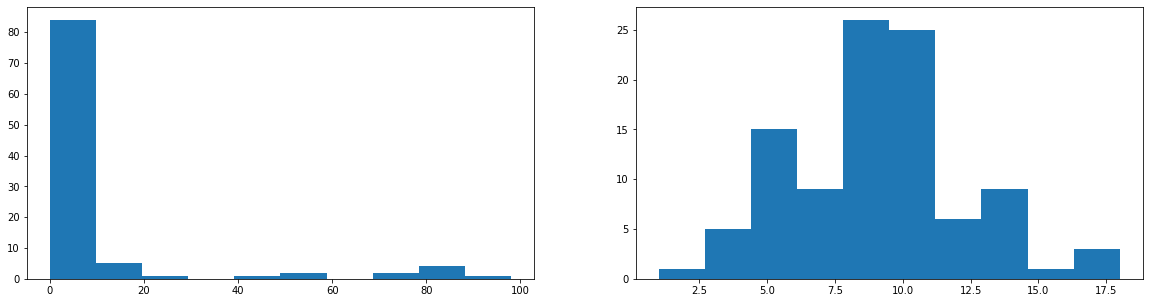

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(AOut,axis=1))

plt.subplot(1,2,2)
plt.hist(np.sum(AOut,axis=0))

(array([ 7.,  9.,  0., 11.,  0., 24., 38.,  0.,  9.,  2.]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <a list of 10 Patch objects>)

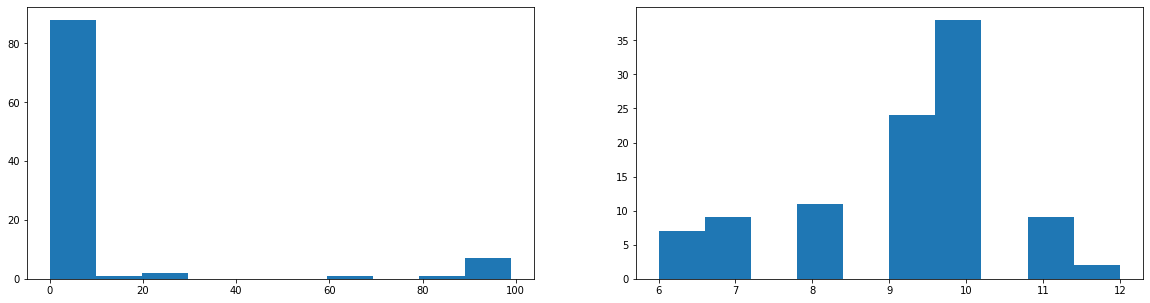

In [11]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(A,axis=1))

plt.subplot(1,2,2)
plt.hist(np.sum(A,axis=0))

(array([ 1.,  5., 15.,  9., 26., 25.,  6.,  9.,  1.,  3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

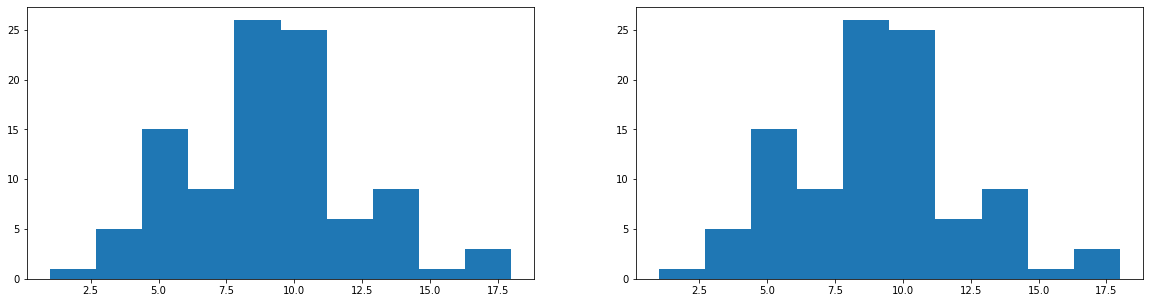

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(ARand,axis=0))

plt.subplot(1,2,2)
plt.hist(np.sum(AOut,axis=0))

(array([ 1.,  5.,  7., 16., 14., 15., 19.,  9.,  5.,  9.]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <a list of 10 Patch objects>)

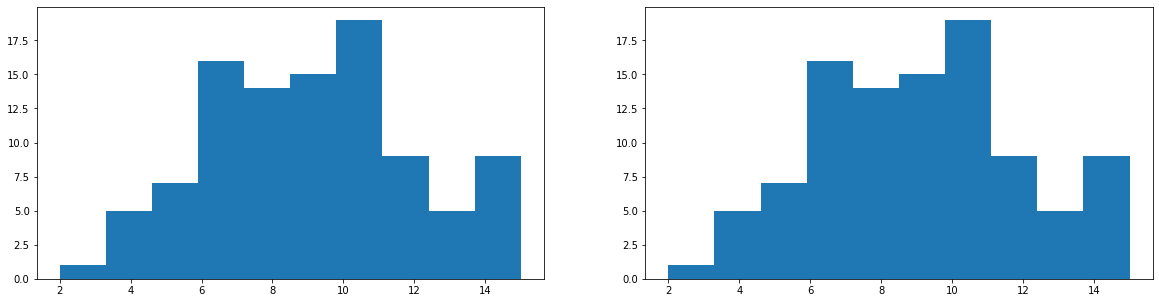

In [13]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1,2,1)
plt.hist(np.sum(ARand,axis=1))

plt.subplot(1,2,2)
plt.hist(np.sum(AIn,axis=1))

In [14]:
np.sum(ARand,axis=0) - np.sum(AOut,axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
np.sum(ARand,axis=1) - np.sum(AIn,axis=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Schematic example to understand the consensus kernel

In [16]:
def plotHeat(tauVec,L):
    
    lenTau = len(tauVec)
    cmap = 'viridis'
    plt.rcParams['figure.figsize'] = [20, 10]

    for ind,tau in enumerate(tauVec):
    
        h = linalg.expm(-tau * L)  # heat dispersion component
        plt.subplot(1,lenTau,ind+1)
        plt.imshow(h, cmap=cmap)
        plt.colorbar(orientation='horizontal')
        
    plt.show()

In [17]:
#DRAW THE TOPOLOGY IN A PIECE OF PAPER TO UNDERSTAND WHY THEY DIFFUSE THE WAY THEY DO

#A = np.array([[0,0,0,1,0],[1,0,0,0,0],[1,0,0,0,0],[0,1,1,0,1],[0,0,1,0,0]])

#A = np.array([[0,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[0,1,1,0,1],[0,0,1,0,0]])

A = np.array([[0,0,0,0,0],[0,0,0,0,0],[1,0,0,0,0],[0,0,1,0,1],[0,0,1,0,0]])

print(A)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 1]
 [0 0 1 0 0]]


In [18]:
DinVec = np.sum(A,axis=0); Din = np.diag(DinVec); Lin = Din - A




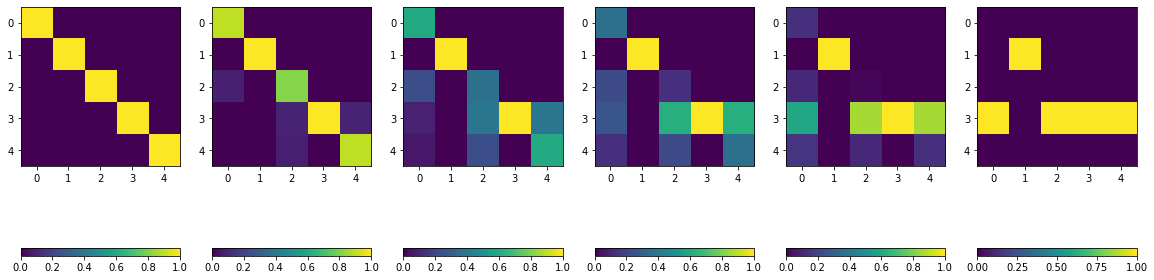

In [19]:
tauVec = [0,0.1,0.5,1,2,40]

plotHeat(tauVec,Lin)

In [20]:
hIn = linalg.expm(-1 * Lin)
print(hIn)

hIn2 = linalg.expm(-2 * Lin)
print()
print(hIn2)

hIn3 = linalg.expm(-40 * Lin)
print()
print(hIn3)

[[0.36787944 0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.23254416 0.         0.13533528 0.         0.        ]
 [0.26424112 0.         0.63212056 1.         0.63212056]
 [0.13533528 0.         0.23254416 0.         0.36787944]]

[[0.13533528 0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.11701964 0.         0.01831564 0.         0.        ]
 [0.59399415 0.         0.86466472 1.         0.86466472]
 [0.15365092 0.         0.11701964 0.         0.13533528]]

[[4.24835426e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.24835426e-18 0.00000000e+00 1.80485139e-35 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.65685816e-16 0.00000000e+00 4.24835426e-18 0.00000000e+00
  4.24835426e-18]]


In [21]:
# THE SUMS ALONG THE ROWS INDICATE THE CONCENTRATION OF EACH NODE

np.sum(hIn,axis=1)

array([0.36787944, 1.        , 0.36787944, 2.52848224, 0.73575888])

In [22]:
np.sum(hIn2,axis=1)

array([0.13533528, 1.        , 0.13533528, 3.32332358, 0.40600585])

In [23]:
np.sum(hIn3,axis=1)

array([4.24835426e-18, 1.00000000e+00, 4.24835426e-18, 4.00000000e+00,
       1.74182524e-16])